In [1]:
# MLP : Bengio et al. 2003 - https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [2]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn.functional as F

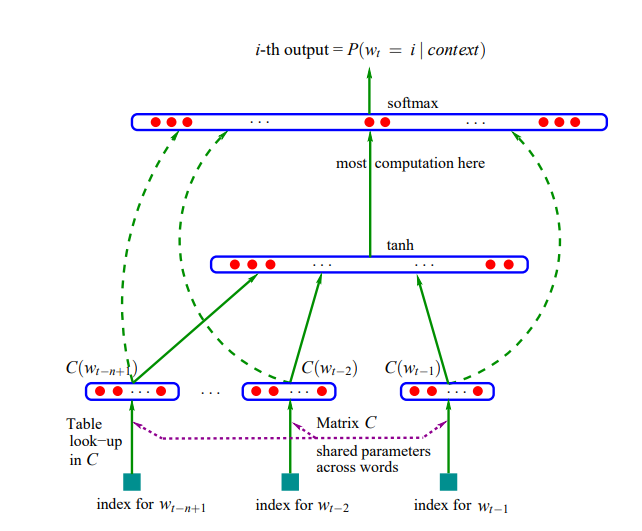

In [3]:
# read in all the names:
words = open("names.txt", "r").read().splitlines()
len(words)

32033

In [4]:
# Create a look up list for unique characters
chars = sorted(list(set(''.join(words))))# ''.join(words) will concatenate all the strings in 'words', then put it into a set
stoi = {s:i+1 for i,s in enumerate(chars)} # enumerate creates an iterator for the list and add index for the items
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# Build the dataset:

block_size = 3 # context length: Basically how many characters do we take to predict the next one?
X, Y = [], [] # X - input, Y - label
for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context),':',context, '--->', itos[ix], ':', [ix]) # For example: '0' is the index of '.'
        context = context[1:] + [ix] # crop and append: Always crop the first character and append a new one to the end
        
X = torch.tensor(X)
Y = torch.tensor(Y)

print("Size of input: ", len(X))

emma
... : [0, 0, 0] ---> e : [5]
..e : [0, 0, 5] ---> m : [13]
.em : [0, 5, 13] ---> m : [13]
emm : [5, 13, 13] ---> a : [1]
mma : [13, 13, 1] ---> . : [0]
olivia
... : [0, 0, 0] ---> o : [15]
..o : [0, 0, 15] ---> l : [12]
.ol : [0, 15, 12] ---> i : [9]
oli : [15, 12, 9] ---> v : [22]
liv : [12, 9, 22] ---> i : [9]
ivi : [9, 22, 9] ---> a : [1]
via : [22, 9, 1] ---> . : [0]
ava
... : [0, 0, 0] ---> a : [1]
..a : [0, 0, 1] ---> v : [22]
.av : [0, 1, 22] ---> a : [1]
ava : [1, 22, 1] ---> . : [0]
isabella
... : [0, 0, 0] ---> i : [9]
..i : [0, 0, 9] ---> s : [19]
.is : [0, 9, 19] ---> a : [1]
isa : [9, 19, 1] ---> b : [2]
sab : [19, 1, 2] ---> e : [5]
abe : [1, 2, 5] ---> l : [12]
bel : [2, 5, 12] ---> l : [12]
ell : [5, 12, 12] ---> a : [1]
lla : [12, 12, 1] ---> . : [0]
sophia
... : [0, 0, 0] ---> s : [19]
..s : [0, 0, 19] ---> o : [15]
.so : [0, 19, 15] ---> p : [16]
sop : [19, 15, 16] ---> h : [8]
oph : [15, 16, 8] ---> i : [9]
phi : [16, 8, 9] ---> a : [1]
hia : [8, 9, 1] ---> . :

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [7]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [8]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [9]:
# Create the lookup table for the characters
C = torch.randn((27, 2)) # Each row has a 2 dimensional embedding, in the paper of MLP, they could use for example 30 dimension instead of 2.
C

tensor([[ 4.8062e-01, -1.2826e+00],
        [-1.9510e-02,  3.8031e-01],
        [-5.7896e-01,  3.0991e-01],
        [-6.5424e-01, -7.8953e-01],
        [ 5.9386e-01,  2.7037e-01],
        [ 1.0790e-01,  2.8919e-01],
        [ 9.6250e-01,  7.9703e-01],
        [-6.0435e-01, -3.8770e-01],
        [-1.0749e+00,  4.0399e-01],
        [ 6.7790e-01, -2.6047e-01],
        [ 3.6094e-01, -2.0038e-02],
        [ 1.8739e-01,  3.4895e-01],
        [ 1.6111e+00, -4.5740e-01],
        [ 8.2851e-01,  2.0994e-01],
        [ 2.1070e-01,  1.5228e+00],
        [ 6.2104e-01, -1.5395e+00],
        [ 4.9938e-01,  7.5607e-01],
        [ 4.2078e-01, -4.8542e-01],
        [ 4.2293e-01,  1.4758e+00],
        [-1.8129e-01, -6.0673e-01],
        [ 7.9185e-01,  7.3277e-01],
        [ 1.2380e-04, -1.5617e+00],
        [ 1.5613e+00, -2.4559e-01],
        [-1.5291e+00,  1.2741e+00],
        [-4.4146e-01, -3.5715e+00],
        [-9.7598e-01, -6.2438e-01],
        [-6.5390e-01,  3.4253e-02]])

In [10]:
F.one_hot(torch.tensor(5), num_classes=27) # Creates a one-hot vector and the 5th dimension is 1
F.one_hot(torch.tensor(5), num_classes=27).float() @ C # This is equivalent to C[5]

tensor([0.1079, 0.2892])

In [11]:
C[[5,6,7]] # Gets the row: 5,6,7

tensor([[ 0.1079,  0.2892],
        [ 0.9625,  0.7970],
        [-0.6043, -0.3877]])

In [12]:
C[X] # Same as above, to get multiple rows. For example X[0] = [0,0,0] , C[X[0]] or X[X][0] = [C[0], C[0], C[0]]

tensor([[[ 0.4806, -1.2826],
         [ 0.4806, -1.2826],
         [ 0.4806, -1.2826]],

        [[ 0.4806, -1.2826],
         [ 0.4806, -1.2826],
         [ 0.1079,  0.2892]],

        [[ 0.4806, -1.2826],
         [ 0.1079,  0.2892],
         [ 0.8285,  0.2099]],

        [[ 0.1079,  0.2892],
         [ 0.8285,  0.2099],
         [ 0.8285,  0.2099]],

        [[ 0.8285,  0.2099],
         [ 0.8285,  0.2099],
         [-0.0195,  0.3803]],

        [[ 0.4806, -1.2826],
         [ 0.4806, -1.2826],
         [ 0.4806, -1.2826]],

        [[ 0.4806, -1.2826],
         [ 0.4806, -1.2826],
         [ 0.6210, -1.5395]],

        [[ 0.4806, -1.2826],
         [ 0.6210, -1.5395],
         [ 1.6111, -0.4574]],

        [[ 0.6210, -1.5395],
         [ 1.6111, -0.4574],
         [ 0.6779, -0.2605]],

        [[ 1.6111, -0.4574],
         [ 0.6779, -0.2605],
         [ 1.5613, -0.2456]],

        [[ 0.6779, -0.2605],
         [ 1.5613, -0.2456],
         [ 0.6779, -0.2605]],

        [[ 1.5613, -0

In [13]:
C[X][0]

tensor([[ 0.4806, -1.2826],
        [ 0.4806, -1.2826],
        [ 0.4806, -1.2826]])

In [14]:
C[X][12,2] 

tensor([ 0.4806, -1.2826])

In [15]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [16]:
W1 = torch.randn((6, 100)) # 6 because we have from the emb shape that 3 x 2, and each neuron in the embeddings need weight to the next neurons
b1 = torch.randn(100)

In [17]:
emb @ W1 + b1 # Wrong dimension -> [32, 3, 2] @ [6, 100] cannot be multiplied so the 3, 2 needs to be crunched to be 6

RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)

In [18]:
# concetanate
# torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

# https://pytorch.org/docs/stable/generated/torch.unbind.html - unbind removes a tensor dimension
torch.cat(torch.unbind(emb, 1), 1).shape # This way it is much less efficient, since it will allocate new memory

torch.Size([32, 6])

In [19]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [20]:
a.shape

torch.Size([18])

In [21]:
# https://pytorch.org/docs/stable/generated/torch.Tensor.view.html
# Great article about these python internals: http://blog.ezyang.com/2019/05/pytorch-internals/
# .view is really efficient, since it just modifies the logical output of the physical order
a.view(2, 9) # Convert it to a 2x9 tensor

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [22]:
emb.view(32,6)

tensor([[ 0.4806, -1.2826,  0.4806, -1.2826,  0.4806, -1.2826],
        [ 0.4806, -1.2826,  0.4806, -1.2826,  0.1079,  0.2892],
        [ 0.4806, -1.2826,  0.1079,  0.2892,  0.8285,  0.2099],
        [ 0.1079,  0.2892,  0.8285,  0.2099,  0.8285,  0.2099],
        [ 0.8285,  0.2099,  0.8285,  0.2099, -0.0195,  0.3803],
        [ 0.4806, -1.2826,  0.4806, -1.2826,  0.4806, -1.2826],
        [ 0.4806, -1.2826,  0.4806, -1.2826,  0.6210, -1.5395],
        [ 0.4806, -1.2826,  0.6210, -1.5395,  1.6111, -0.4574],
        [ 0.6210, -1.5395,  1.6111, -0.4574,  0.6779, -0.2605],
        [ 1.6111, -0.4574,  0.6779, -0.2605,  1.5613, -0.2456],
        [ 0.6779, -0.2605,  1.5613, -0.2456,  0.6779, -0.2605],
        [ 1.5613, -0.2456,  0.6779, -0.2605, -0.0195,  0.3803],
        [ 0.4806, -1.2826,  0.4806, -1.2826,  0.4806, -1.2826],
        [ 0.4806, -1.2826,  0.4806, -1.2826, -0.0195,  0.3803],
        [ 0.4806, -1.2826, -0.0195,  0.3803,  1.5613, -0.2456],
        [-0.0195,  0.3803,  1.5613, -0.2

In [23]:
# Now this will work perfectly since the dimensions will be perfect
# -1 as the first parameter: python will fill out logically what should be there since it knows that the number of elements should be the same after calling the view 
# '+ b1' : should pay attention because of the broadcasting should be correct, since it is a [1, 100] tensor, it will vertically add to the 'emb.view(-1,6) @ W1'
h = torch.tanh(emb.view(-1,6) @ W1 + b1) 
print(h)
h.shape

tensor([[ 0.9989, -0.8996,  0.9986,  ..., -0.9153, -0.6443, -0.4727],
        [ 0.9981, -0.1529,  0.9712,  ..., -0.9213, -0.9401, -0.9524],
        [ 0.9995, -0.2153,  0.9561,  ...,  0.5145, -0.7774, -0.9576],
        ...,
        [ 0.9990,  0.5245,  0.6180,  ...,  0.0361, -0.5285, -0.5816],
        [ 0.9872, -0.8483, -0.9805,  ...,  0.6144,  0.2985,  0.9894],
        [-0.9974, -0.7907, -0.0823,  ..., -0.9982,  0.6014, -0.9727]])


torch.Size([32, 100])

In [24]:
W2 = torch.randn((100, 27)) # 27, because we have 27 possible character to come next
b2 = torch.randn(27) 

In [28]:
logits = h @ W2 + b2

In [29]:
logits.shape

torch.Size([32, 27])

In [30]:
logits

tensor([[-1.5043e+01,  3.5704e+00, -2.9899e+00, -1.6886e+00,  7.2659e+00,
          3.4012e-01, -4.6652e-01, -9.8034e-01, -4.8024e+00, -1.0800e+01,
          4.8955e+00, -3.3278e+00, -6.6926e+00,  6.4476e+00,  1.5585e+00,
          9.5058e+00, -2.9082e+00, -9.5392e+00, -3.5436e+00,  6.1679e+00,
         -2.9021e+00, -1.7835e+00, -7.9345e+00,  4.4711e+00,  8.2299e+00,
         -1.4242e+01,  3.3845e+00],
        [-1.1145e+01,  6.6309e+00, -2.5794e+00,  2.4167e+00,  8.6962e+00,
         -7.5866e-01, -6.7136e+00, -6.9599e+00, -3.1578e+00, -1.0736e+01,
          5.8771e+00, -2.5665e+00, -1.3949e+01,  3.7320e+00, -4.7988e+00,
         -2.2550e+00,  1.7519e-01, -1.0886e+01, -3.6113e+00,  6.8107e+00,
         -3.3856e+00,  1.2656e+00,  1.5005e+00,  1.8598e+00,  8.3591e+00,
         -1.5967e+01,  3.3431e-01],
        [-8.0753e+00, -1.3041e+00,  2.2327e+00, -1.0954e+00,  1.0437e+01,
         -4.4060e+00,  1.7295e+00, -8.9446e+00, -3.4621e+00, -9.0783e+00,
          1.7203e+00,  5.3648e-01, -6.46

In [31]:
counts = logits.exp()

In [44]:
prob = counts / counts.sum(1, keepdims=True)
print(prob.shape)
prob[0].sum() # Normalized to probability
prob # Each dimension contains the probability to which character should come next

torch.Size([32, 27])


tensor([[1.4628e-11, 1.7747e-03, 2.5118e-06, 9.2289e-06, 7.1455e-02, 7.0179e-05,
         3.1325e-05, 1.8739e-05, 4.1005e-07, 1.0187e-09, 6.6769e-03, 1.7916e-06,
         6.1937e-08, 3.1524e-02, 2.3732e-04, 6.7113e-01, 2.7256e-06, 3.5946e-09,
         1.4439e-06, 2.3834e-02, 2.7425e-06, 8.3930e-06, 1.7888e-08, 4.3680e-03,
         1.8737e-01, 3.2608e-11, 1.4735e-03],
        [1.1705e-09, 6.1429e-02, 6.1431e-06, 9.0815e-04, 4.8453e-01, 3.7942e-05,
         9.8383e-08, 7.6906e-08, 3.4450e-06, 1.7628e-09, 2.8906e-02, 6.2227e-06,
         7.0923e-11, 3.3838e-03, 6.6758e-07, 8.4969e-06, 9.6536e-05, 1.5162e-09,
         2.1890e-06, 7.3528e-02, 2.7433e-06, 2.8724e-04, 3.6331e-04, 5.2037e-04,
         3.4587e-01, 9.4218e-12, 1.1319e-04],
        [7.8802e-09, 6.8737e-06, 2.3618e-04, 8.4690e-06, 8.6388e-01, 3.0908e-07,
         1.4279e-04, 3.3037e-09, 7.9434e-07, 2.8901e-09, 1.4149e-04, 4.3308e-05,
         3.9347e-08, 1.2587e-01, 1.5428e-05, 8.6128e-07, 6.0804e-06, 1.5008e-11,
         6.1719e-

In [50]:
# torch.arange(32) will go through each 32 dimension (iterates the rows) and and Y - label by each row grabs that column as given by Y, gives back the probability of that character we would like to predict
prob[torch.arange(32), Y]

tensor([7.0179e-05, 3.3838e-03, 1.2587e-01, 5.2132e-09, 3.3200e-10, 6.7113e-01,
        5.3203e-08, 1.6058e-08, 4.0674e-07, 7.2907e-06, 5.2939e-09, 2.4727e-09,
        1.7747e-03, 4.3494e-04, 2.0386e-07, 8.3047e-06, 1.0187e-09, 9.2176e-02,
        7.4839e-03, 1.0531e-07, 2.4961e-08, 4.5855e-06, 8.5337e-10, 2.3816e-12,
        2.7609e-09, 2.3834e-02, 4.1275e-03, 2.6842e-08, 6.3034e-06, 3.6081e-11,
        5.2841e-10, 7.6281e-05])

In [55]:
# Calculate the loss - the function we would like to minimize is the loss function
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(13.5825)

### Clean version

In [176]:
block_size = 3 # context length: Basically how many characters do we take to predict the next one?
X, Y = [], [] # X - input, Y - label
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop and append: Always crop the first character and append a new one to the end
        
X = torch.tensor(X)
Y = torch.tensor(Y)

size = len(X)

print("Size of input: ", len(X))

Size of input:  228146


In [177]:
X.shape, Y.shape # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [178]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [179]:
sum(p.nelement() for p in parameters) # Number of parameters in total

3481

In [170]:
# Creating a list of possible learning rates,between 0 and 1
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [180]:
for p in parameters:
    p.requires_grad = True

In [186]:
lri = []
lossi = []

for i in range(10000):
    
    # Minibatch construction - it is needed to optimize, since the whole dataset is too large for that many iteration
    ix = torch.randint(0, X.shape[0], (32,)) # mini batch size is 32
    
    # Forward pass:
    emb = C[X[ix]] # For example: [32, 3, 2]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # [32, 100]
    logits = h @ W2 + b2 # [32, 100] @ [100, 27] = [32, 27]
    # Cross-entropy function: ------------------------
    # counts = logits.exp()
    # probs = counts / counts.sum(1, keepdim=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    # ------------------------------------------------
    # F.cross_entropy(arg1, arg2) - https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html - is equivalent to above:
    loss = F.cross_entropy(logits, Y[ix])
    if i % 1000 == 0:
        print(loss.item())

    # Backward pass:
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update:
    # lr = lrs[i]
    lr = 0.01 # Based on the diagram 10**-1=0.1
    for p in parameters:
        p.data += -lr * p.grad
        
    # Track stats:
    # lri.append(lre[i])
    # lossi.append(loss.item())
        
print(f'Final loss for the mini batch: {loss.item()}')

2.291398763656616
2.2863223552703857
2.614124059677124
2.4327094554901123
2.432443380355835
2.3256642818450928
2.503181219100952
2.323615550994873
2.07649302482605
2.286106824874878
Final loss for the mini batch: 2.3647642135620117


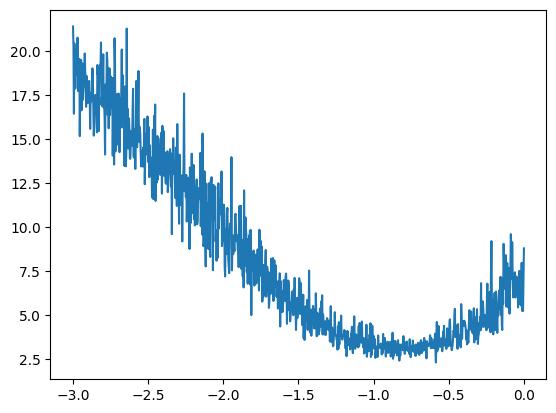

In [173]:
# Plot the stats:
plt.plot(lri, lossi)

In [187]:
emb = C[X] 
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Y)

print(f'Final loss for the whole dataset: {loss.item()}')

Final loss for the whole dataset: 2.340898275375366


## Split our dataset:

#### training split / dev/validation split / test split
#### 80%, 10%, 10%

In [ ]:
block_size = 3 
X, Y = [], [] 
for w in words[:5]:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop and append: Always crop the first character and append a new one to the end
        
X = torch.tensor(X)
Y = torch.tensor(Y)